In [ ]:
# imports
%load_ext autoreload
%autoreload 2
import time
from timeit import default_timer as timer
from victor_thesis_experiments_testing import *
from victor_thesis_utils import *
from victor_thesis_landscapes import *
from victor_thesis_plots import *
from victor_thesis_metrics import *
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count

In [ ]:
# EXPERIMENT RESULTS HERE
%load_ext autoreload
%autoreload 2
from victor_thesis_results_processing import *    
"""loads and processes different results and combined results into text and plots that can be used for the final thesis or testing purposes
    """
run_id = "16_6_4_10_13_3_14"
datatype_labels = ["random", "orthogonal","average rank","dependent"]
results, configs = get_results(run_id)
#get data of all runs by schmidt rank
combined_results_list = []
combined_results_list.append(combine_results(get_results_where(results, configs, schmidt_rank=1)))
combined_results_list.append(combine_results(get_results_where(results, configs, schmidt_rank=2)))
combined_results_list.append(combine_results(get_results_where(results, configs, schmidt_rank=3)))
combined_results_list.append(combine_results(get_results_where(results, configs, schmidt_rank=4)))
visualize_metrics(combined_results_list, "Schmidt Rank", "Mean and standard deviation of all metrics by Schmidt Rank \n(over all data types)")
print_metrics(combined_results_list, "type 1, by schmidt rank")
#get data of all runs except linearly dependent data by number of datapoints
combined_results_list = []
r1=[]
r1+=get_results_where(results, configs, type_of_data=1, num_data_points=1)
r1+=get_results_where(results, configs, type_of_data=2, num_data_points=1)
r1+=get_results_where(results, configs, type_of_data=4, num_data_points=1)
r2=[]
r2+=get_results_where(results, configs, type_of_data=1, num_data_points=2)
r2+=get_results_where(results, configs, type_of_data=2, num_data_points=2)
r2+=get_results_where(results, configs, type_of_data=4, num_data_points=2)
r3=[]
r3+=get_results_where(results, configs, type_of_data=1, num_data_points=3)
r3+=get_results_where(results, configs, type_of_data=2, num_data_points=3)
r3+=get_results_where(results, configs, type_of_data=4, num_data_points=3)
r4=[]
r4+=get_results_where(results, configs, type_of_data=1, num_data_points=4)
r4+=get_results_where(results, configs, type_of_data=2, num_data_points=4)
r4+=get_results_where(results, configs, type_of_data=4, num_data_points=4)
combined_results_list.append(combine_results(r1))
combined_results_list.append(combine_results(r2))
combined_results_list.append(combine_results(r3))
combined_results_list.append(combine_results(r4))
visualize_metrics(combined_results_list, "Number Of Data Points", "Mean and standard deviation of all metrics by number of data points \n(over all data types except linearly dependent data)")
print_metrics(combined_results_list, "type 1, by schmidt rank")
#get data of linearly dependent data by number of datapoints
combined_results_list = []
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=3, num_data_points=1)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=3, num_data_points=2)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=3, num_data_points=3)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=3, num_data_points=4)))
visualize_metrics(combined_results_list, "Number Of Data Points", "Mean and standard deviation of all metrics by number of data points \n(over linearly dependent data only)")
print_metrics(combined_results_list, "type 1, by schmidt rank")
#get data by datatype
combined_results_list = []
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=1)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=2)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=4)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=3)))
visualize_metrics(combined_results_list, "type of data", "Mean and standard deviation of all metrics by type of data", sample_labels=datatype_labels)
print_metrics(combined_results_list, "type 1, by schmidt rank")



In [ ]:
#CALCULATE METRIC DEVIATIONS
%load_ext autoreload
%autoreload 2
from victor_thesis_results_processing import *
"""cell used to calculate the colors for the table of the thesis
"""
run_id = "16_6_4_10_13_3_14"
datatype_labels = ["random", "orthogonal","dependent","average rank"]
results, configs = get_results(run_id)
combined_results_list = []
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=1)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=2)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=3)))
combined_results_list.append(combine_results(get_results_where(results, configs, type_of_data=4)))
calculate_deviations(combined_results_list, datatype_labels)

tensor([[[ 0.1076-0.5764j],
         [-0.7628+0.2727j]],

        [[ 0.2477+0.3764j],
         [-0.8891+0.0808j]]], dtype=torch.complex128)


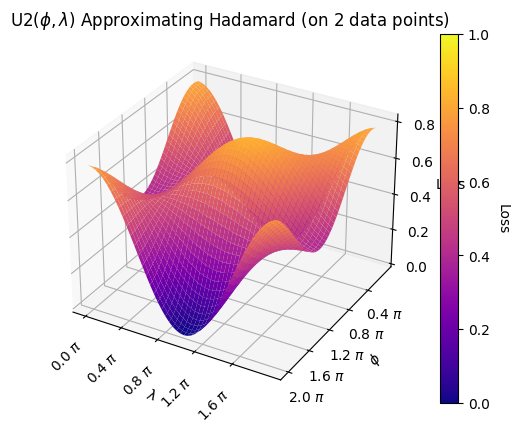

In [4]:
# BASIC LOSS LANDSCAPE FIGURE
from datetime import datetime
from torch import tensor
from victor_thesis_results_processing import get_results
from victor_thesis_utils import *
from victor_thesis_landscapes import *
from victor_thesis_plots import *
from victor_thesis_metrics import *
"""cell used to generate the basic loss landscape figure of the masters thesis paper"""


def figure_basic_loss_landscape():
    qnn = get_qnn("CudaU2", list(range(1)), 1, device="cpu")
    U = torch.tensor(np.array([[1, 1], [1, -1]]) / np.sqrt(2), dtype=torch.complex128, device="cpu")
    #entangled_inputs = generate_random_datapoints(2, 1, U)
    entangled_inputs= tensor([[[ 0.1076-0.5764j], [-0.7628+0.2727j]], [[ 0.2477+0.3764j], [-0.8891+0.0808j]]], dtype=torch.complex128)
    print(entangled_inputs)
    loss_ent = generate_2d_loss_landscape(50, entangled_inputs, U, qnn)
    plot_3d_loss_landscape(
        loss_ent, "U2", f"Hadamard (on 2 data points)"
    )
figure_basic_loss_landscape()

In [ ]:
# test unitary parametrization
from qnns.cuda_qnn import CudaPennylane

torch.set_num_threads(1)
torch.multiprocessing.set_sharing_strategy('file_system')

num_qubits = 1
qnn = CudaPennylane(num_wires=num_qubits, num_layers=2, device='cpu')
random_unitary = torch.tensor(np.array(random_unitary_matrix(num_qubits)), dtype=torch.complex128, device="cpu")
print("tensor V",qnn.get_tensor_V())
print("params",qnn.params)
print("unitary",random_unitary)
non_entangled_inputs = generate_random_datapoints(3, num_qubits, random_unitary)
non_entangled_landscape, _= generate_loss_landscape(3, 6 , non_entangled_inputs, random_unitary, qnn) 

In [ ]:
# fourier testing
"""cell used to test everything related to the fourier domain and fourier density"""
# hadamard U2
qnn = get_qnn("CudaU2", list(range(1)), 1, device="cpu")
unitary = torch.tensor(np.array([[1, 1], [1, -1]]) / np.sqrt(2), dtype=torch.complex128, device="cpu")
############
# phase R
# qnn = get_qnn("CudaR", list(range(1)), 1, device="cpu")
# unitary = torch.tensor(np.array([[1, 0], [0, 1j]]), dtype=torch.complex128, device="cpu")
############
num_ticks = 4
# generate data points
non_entangled_inputs = generate_random_datapoints(5, 1, unitary)
entangled_inputs = generate_random_datapoints(5, 2, unitary)
z_o_inputs = get_zero_one_datapoints()
# get 2d landscapes
loss_z_o= generate_2d_loss_landscape(
    num_ticks, z_o_inputs, unitary, qnn
)
loss_non_ent= generate_2d_loss_landscape(
    num_ticks, non_entangled_inputs, unitary, qnn
)
loss_ent= generate_2d_loss_landscape(
    num_ticks, entangled_inputs, unitary, qnn
)
landscapes = [loss_z_o, loss_non_ent, loss_ent]

#test fourier stuff
print("fourier stuff")
fourier_landscape_z_o = get_fourier_landscape(z_o_inputs, unitary, qnn,num_ticks).values
z_o_fd, z_o_f_plot = calc_fourier_density(landscapes[0])
print("FD manual custom:", z_o_fd)
fourier_landscape_non_entangled = get_fourier_landscape(non_entangled_inputs, unitary, qnn,num_ticks).values
n_e_fd, non_ent_f_plot = calc_fourier_density(landscapes[1])
print("FD manual custom:", n_e_fd)
fourier_landscape_entangled = get_fourier_landscape(entangled_inputs, unitary, qnn,num_ticks).values
e_fd, ent_f_plot = calc_fourier_density(landscapes[2])
print("FD manual custom:", e_fd)

# differences possibly explained by different loss landscape sampling
plot_row(landscapes, ["zero one", "non ent","entangled"], "Hadamard", "U2", mode="default")
print("real values")
plot_fourier_row(np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).real), ["zero one, with lib", "non entangled, with lib","entangled, with lib"])
print("absolute sum: ", np.sum(np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).real)))
plot_fourier_row(np.absolute(np.array([z_o_f_plot, non_ent_f_plot, ent_f_plot]).real), ["zero one, manual", "non entangled, manual","entangled, manual"])
print("absolute sum: ", np.sum(np.absolute(np.array([[z_o_f_plot, non_ent_f_plot, ent_f_plot]]).real)))

print("imaginary values")
plot_fourier_row(np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).imag), ["zero one, with lib", "non entangled, with lib","entangled, with lib"])
print("absolute sum: ", np.sum(np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).imag)))
plot_fourier_row(np.absolute(np.array([z_o_f_plot, non_ent_f_plot, ent_f_plot]).imag), ["zero one, manual", "non entangled, manual","entangled, manual"])
print("absolute sum: ", np.sum(np.absolute(np.array([[z_o_f_plot, non_ent_f_plot, ent_f_plot]]).imag)))

print("sum of real and imaginary values")
plot_fourier_row(np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).imag)+np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).real), ["zero one, with lib", "non entangled, with lib","entangled, with lib"])
print("absolute sum: ", np.sum(np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).imag)+np.absolute(np.array([fourier_landscape_z_o, fourier_landscape_non_entangled, fourier_landscape_entangled]).real)))
plot_fourier_row(np.absolute(np.array([z_o_f_plot, non_ent_f_plot, ent_f_plot]).imag)+np.absolute(np.array([z_o_f_plot, non_ent_f_plot, ent_f_plot]).real), ["zero one, manual", "non entangled, manual","entangled, manual"])
print("absolute sum: ", np.sum(np.absolute(np.array([[z_o_f_plot, non_ent_f_plot, ent_f_plot]]).imag)+np.absolute(np.array([[z_o_f_plot, non_ent_f_plot, ent_f_plot]]).real)))
# print(calc_fourier_density(landscapes[0]))
# print(calc_fourier_density(landscapes[1]))
# print(calc_fourier_density(landscapes[2]))


In [ ]:
# EXP on Hadamard
run_hadamard()

In [ ]:
# EXP on Pauli-X
run_pauli_x()

In [ ]:
# EXP on Pauli-Y
run_pauli_y()

In [ ]:
# EXP on Pauli-Z
run_pauli_z()

In [ ]:
# EXP on Phase (S)
run_phase_s()